# Module 1.4 - auto-ignition

In this module we will look at auto-ignition of a gas and the ignition delay time. This module is based on the cantera tutorial:

https://cantera.org/examples/jupyter/reactors/batch_reactor_ignition_delay_NTC.ipynb.html

For certain temperatures and pressures, a mixture of fuel and air can auto-ignite. It can take minutes or hours before a mixture auto-ignites and it is important to know under which circumstances a mixture can ignite, and what the ignition delay time is.

In [1]:
# use notebook for jupyter notebook
#%matplotlib notebook
# use inline for jupyter labs
%matplotlib inline
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import time

In this example we will choose n-heptane as the gas. For a representative kinetic model, we use the 160 species mechanism by Seiser et al. , Proc. Comb. Inst. (2000)
The mechanism is included with the cantera distribution for jupyter. You can also find it here:
https://github.com/Cantera/cantera-jupyter/tree/master/reactors/data

In [2]:
gas = ct.Solution('seiser.cti')



**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767


Define reactor conditions : temperature, pressure, fuel, stoichiometry. We consider the gas to be an ideal gas. 

In [3]:
# Define the reactor temperature and pressure
reactorTemperature = 1000 #Kelvin
reactorPressure = 101325.0 #Pascals

gas.TP = reactorTemperature, reactorPressure

FUEL = 'nc7h16'
OXIDIZER={'o2':1.0, 'n2':3.76}

# Define the fuel, oxidizer and set the fuel equivalence ratio to stoichiometry
gas.set_equivalence_ratio(phi=1.0, fuel=FUEL, oxidizer=OXIDIZER)

# Create a batch reactor object and add it to a reactor network
# In this example, the batch reactor will be the only reactor
# in the network
r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
reactorNetwork = ct.ReactorNet([r])

# Make a list of all variables for which we will store data
stateVariableNames = [r.component_name(item) for item in range(r.n_vars)]
print(stateVariableNames)

['mass', 'volume', 'temperature', 'n2', 'ch3', 'h', 'ch4', 'h2', 'oh', 'h2o', 'o', 'c2h6', 'c2h5', 'hco', 'co', 'co2', 'o2', 'h2o2', 'ho2', 'c2h4', 'ch3oh', 'ch2oh', 'ch3o', 'ch2o', 'c2h2', 'c2h3', 'c2h', 'hcco', 'ch2', 'ch', 'ch2co', 'ch2(s)', 'pc2h4oh', 'ch3co', 'ch3cho', 'c3h5-s', 'c3h4-p', 'c3h5-a', 'c3h6', 'c3h4-a', 'ch3chco', 'c3h5-t', 'c4h6', 'nc3h7', 'ic3h7', 'c3h8', 'c5h9', 'c4h7', 'c4h8-1', 'sc4h9', 'pc4h9', 'ch3coch3', 'ch3coch2', 'c2h5co', 'c2h5cho', 'c5h10-1', 'ch2cho', 'c5h11-1', 'c5h11-2', 'c2h5o', 'c2h5o2', 'ch3o2', 'ch3o2h', 'c3h2', 'o2c2h4oh', 'c2h4o2h', 'c2h3co', 'c2h3cho', 'c3h5o', 'c3h6o1-2', 'c3h6ooh1-2', 'c3h6ooh2-1', 'nc3h7o', 'ic3h7o', 'nc3h7o2', 'ic3h7o2', 'c4h7o', 'c4h8ooh1-3o2', 'c4h8ooh1-3', 'nc4ket13', 'c4h8ooh1-2', 'c4h8o1-3', 'pc4h9o2', 'c3h3', 'hocho', 'c2h3o1,2', 'nc3h7cho', 'nc3h7co', 'c3h6cho-2', 'ch2ch2coch3', 'c2h5coch2', 'c2h5coc2h4p', 'nc3h7coch2', 'nc4h9cho', 'nc4h9co', 'hoch2o', 'c6h13-1', 'c6h12-1', 'c6h11', 'nc7h16', 'c7h15-1', 'c7h15-2', 'c7

We define a separate function to determine the ignition delay time. Especially for large functions that will be re-used, this is good practise. 

In [4]:
def ignitionDelay(time, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration. This only works if there is a peak at the ignition time.
    """
    return time[species.index(max(species))]

If you write a python function, the help command will display the message between the triple double-quotes

In [5]:
help(ignitionDelay)

Help on function ignitionDelay in module __main__:

ignitionDelay(time, species)
    This function computes the ignition delay from the occurence of the
    peak in species' concentration. This only works if there is a peak at the ignition time.



In [6]:
# We also determine the computing time for this simulation. Actually, it is just the time that passes 
# between the start of the simulation and the end of the simulation so this time depends on other
# processes running on your machine.
t0 = time.time()

# This is the total time in seconds of the simulation.  If you do not get an ignition within this time, 
# increase this value
estimatedIgnitionDelayTime = 0.1
t = 0
Y_OH=[]
Y_H2=[]
Y_T=[]
time_axis=[]
counter = 1;
while(t < estimatedIgnitionDelayTime):
    # we perform a single time step, letting Cantera take care of the size of the time step.
    t = reactorNetwork.step()
    if (counter%10 == 0):
        # We will save only every 10th value. 
        # Note that the species concentrations taken here are mass fractions Y and not mole fraction X
        L = reactorNetwork.get_state()
        time_axis.append(t)
        Y_T.append(L[2])
        Y_H2.append(L[7])
        Y_OH.append(L[8])
    counter+=1
    
# only a gaseous state, we add time 't' as an extra property
states = ct.SolutionArray(gas, extra=['t'])
    
# We will use the maximum value of OH to compute the ignition delay
tau = ignitionDelay(time_axis,Y_OH)

t1 = time.time()

print('Computed Ignition Delay: {:.3e} seconds. Took {:3.2f}s to compute'.format(tau, t1-t0))

Computed Ignition Delay: 3.248e-02 seconds. Took 1.30s to compute


In [7]:
# global plot settings
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('seaborn-whitegrid')

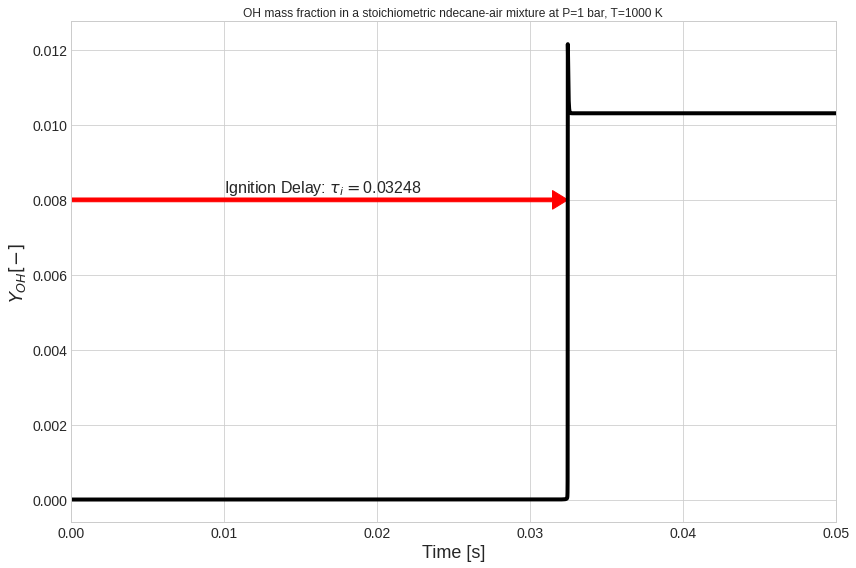

In [9]:
# plot a figure
plt.figure()
# x,y line
plt.plot(time_axis, Y_OH,color='black',linewidth=4)
plt.xlabel('Time [s]')
plt.ylabel('$Y_{OH} [-]$')
plt.title('OH mass fraction in a stoichiometric ndecane-air mixture at P=1 bar, T=1000 K')
plt.xlim([0,0.05])
# plot an arrow
plt.arrow(0, 0.008, tau, 0, width=0.0001, head_width=0.0005,head_length=0.001, length_includes_head=True, color='r', shape='full')
# place text in the figure
plt.annotate(r'Ignition Delay: $\tau_{i}=$%1.5f'%(tau), xy=(0,0), xytext=(0.01, 0.0082), fontsize=16);

## Negative Temperature Coefficient (NTC)

A common benchmark for a reaction mechanism is its ability to reproduce the Negative Temperature Coefficient behavior (NTC). Intuitively, as the temperature of an explosive mixture increases, it should ignite faster. But, under certain conditions, we observe the opposite. This is referred to as NTC behavior. NTC does not occur for every fuel, but it does for n-heptane (by the way, the *n* in n-heptane just means *normal*). Reproducing experimentally observed NTC behavior is an important test for any mechanism. We will do this now by computing and visualizing the ignition delay for a wide range of temperatures. We use a slightly different approach compared to above, using temperature as the threshold and stopping immediately when we have reached ignition.

In [11]:
# maximum time [s]
t_end = 10

# time interval of the computation (not the actual numerical timestep)
# note that this interval is the resolution of your time delay
dt = 1e-4

reactorPressure = 1*ct.one_atm
# initialize as an empty list
tau = []

# the array of temperatures 
T = np.arange(600, 1500, 50)

for reactorTemperature in T:
    # We now define ignition as the time where themperature has increased by 400 K
    T_ign = reactorTemperature + 400
    gas.TP = reactorTemperature, reactorPressure
    gas.set_equivalence_ratio(phi=1.0, fuel=FUEL, oxidizer=OXIDIZER)

    # creating a reactor and a reactor nework
    r = ct.IdealGasReactor(gas)
    sim = ct.ReactorNet([r])

    # initializing time and T_stop to 0 at start of every loop
    t = 0.0
    T_stop = 0

    # We only want the ignition point, so we stop as soon as we have reached ignition
    while T_stop < T_ign and t < t_end:
        t = t + dt # in s
        sim.advance(t)
        T_stop = r.T

    if t >= t_end:
        print('Warning: no ignition for temperature ',reactorTemperature)
    else:
        # storing ignition delay times
        tau.append(t*1e3) # in ms
    
    print("initial temperature = ", reactorTemperature, ", ignition time = ",t," seconds")

initial temperature =  600 , ignition time =  0.37399999999997513  seconds
initial temperature =  650 , ignition time =  0.07650000000000116  seconds
initial temperature =  700 , ignition time =  0.0639000000000008  seconds
initial temperature =  750 , ignition time =  0.14600000000000024  seconds
initial temperature =  800 , ignition time =  0.37929999999997455  seconds
initial temperature =  850 , ignition time =  0.42649999999996935  seconds
initial temperature =  900 , ignition time =  0.19829999999999448  seconds
initial temperature =  950 , ignition time =  0.07910000000000124  seconds
initial temperature =  1000 , ignition time =  0.032499999999999904  seconds
initial temperature =  1050 , ignition time =  0.01399999999999997  seconds
initial temperature =  1100 , ignition time =  0.006500000000000004  seconds
initial temperature =  1150 , ignition time =  0.0031999999999999984  seconds
initial temperature =  1200 , ignition time =  0.0017000000000000006  seconds
initial tempera

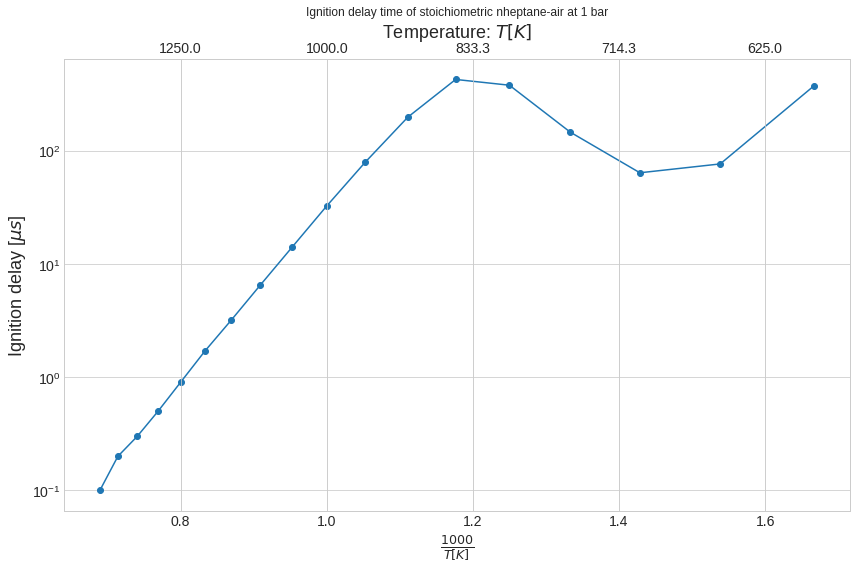

In [12]:
fig = plt.figure()

# We use subplot so we can add a second horizontal axis
# Also remember that if you do not know what a command means, please STOP and look it up!
# Always know what you are doing! 
# In this case I am referring to the magic number 111 below, and also to the difference between plot and subplot
ax = fig.add_subplot(111)

ax.semilogy(1000/np.array(T), tau, 'o-')
ax.set_ylabel('Ignition delay [$\mu s$]')
ax.set_xlabel(r'$\frac{1000}{T [K]}$', fontsize=18)
ax.set_title('Ignition delay time of stoichiometric nheptane-air at 1 bar')
# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000/ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'Temperature: $T [K]$');

The figure above shows the Negative Temperature Coefficient curve of n-heptane. We go from lowest to highest temperate while moving from right to left in the figure. We see that going from 600 K to 800 K the ignition delay time becomes shorter and for higher temperatures the delay time increases again and reaches a maximum at around $T=830 K$. If the temperature increases further, the ignition delay time reduces with temperature. To validate this data with experiments we can use data from (preferably peer-reviewed) literature. 

Experimental data of the ignition delay time of methane for instance can be found in the paper of Hu et al. (2015), two online links to the paper are given below: 
- https://www.sciencedirect.com/science/article/abs/pii/S0016236115005013 
- http://gr.xjtu.edu.cn/upload/22045/Laminar+flame+speeds+and+ignition+delay+times+of+methane-air+mixtures+at+elevated+temperatures+and+pressures.pdf) 

See for instance Figure 7. Data that is available in images can be extracted easily with the right tools, e.g. 

https://automeris.io/WebPlotDigitizer

If you put this data in a python list L=[1,2,3] or a numerical array L=np.array([1,2,3,4]) then you can compare your simulations with the cantera data.

Of course, you can also ask the authors if they can email you the exact data, but I've heard that they are quite busy right now and do not have time to respond until after the end of this course.

# Assignment 1.4
- Compute the ignition delay of a stoichiometric methane-air mixture for the temperature range T=[900,1500] and plot the results as above. Also compute the ignition delay for $\phi=2.0$ and plot in the same figure.
- Compute the ignition delay of a stoichiometric hydrogen-air mixture for the temperature range T=[900,1500] and plot the results as above. Also compute the ignition delay for $\phi=2.0$ and plot in the same figure. Note that hydrogen has a short ignition delay time so be aware of the accuracy.
- Compare with the experimental data of methane from the paper of Hu et al. (2015). Plot the experimental data in the same figure as the simulation data.
- For stoichiometric methane-air, $\phi=1.0, T=1000$, plot the species mass fractions of the major species CO2(t) as well as the minor species OH(t) and HO2(t) for $t=[0,t_{ignition}]$, and use a logarithmic scale for the y-axis. In the description and explanation of the results, comment specifically on the topics of 1.radicals, 2. chemical runaway and 3. explosion limit
- Do the same for $T=800$.
- As always, describe the figures and try to explain the results as accurate as possible.